# Importing libraries and connecting Tensorflow

In [1]:
import os
import uuid
import tensorflow as tf
from matplotlib import pyplot as plt 
import tensorflow_io as tfio
import pandas as pd
import numpy as np
import librosa

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
POS = tf.data.Dataset.list_files(os.path.join('plagiarized')+'\*.wav', shuffle=False).take(229)
NEG = tf.data.Dataset.list_files(os.path.join('negatives')+'\*.wav', shuffle=False).take(229)
ANC = tf.data.Dataset.list_files(os.path.join('non_plagiarized')+'\*.wav', shuffle=False).take(1000)

In [5]:
positives = tf.data.Dataset.zip((ANC, POS, tf.data.Dataset.from_tensor_slices(tf.ones(len(ANC)))))
negatives = tf.data.Dataset.zip((ANC, NEG, tf.data.Dataset.from_tensor_slices(tf.zeros(len(ANC)))))
data = positives.concatenate(negatives)

In [6]:
data.as_numpy_iterator().next()

(b'non_plagiarized\\case100_a.wav', b'plagiarized\\case100_b.wav', 1.0)

# Preprocess

In [7]:
def load_wav_16k_mono(filename):
    # Load encoded wav 
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    waveform_length = tf.shape(wav)[0]
    time = np.linspace(0, int(waveform_length/44100), waveform_length)
    return wav, time

In [8]:
#len(load_wav_16k_mono(ANC.as_numpy_iterator().next()))
wav, time = load_wav_16k_mono('non_plagiarized/case1_a.wav')


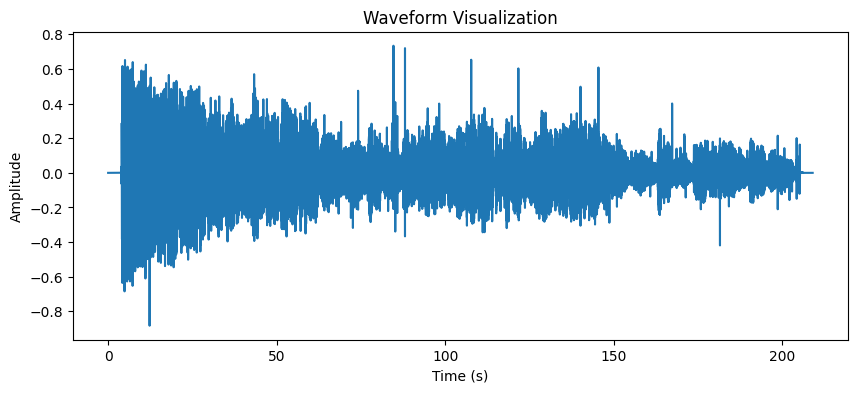

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(time, wav)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform Visualization")
plt.savefig('time_domain_normalized.pdf')
plt.show()


In [10]:
wav

<tf.Tensor: shape=(9240192,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [11]:
13778880 

13778880

In [12]:
from sklearn.preprocessing import minmax_scale
frame_length = 2048
frame_step = 512
target_lower_freq = 0  # Set the desired lower frequency
target_upper_freq = 4000  # Set the desired upper frequency

def equal_len(wav_file, padding = True, num_samples = 13778880):
    # Load the audio file
        file_contents = tf.io.read_file(wav_file)

        wave, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
        wave = tf.squeeze(wave, axis=-1)
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)
        
      
        # wav = wave[:num_samples]
        # zero_padding = tf.zeros([num_samples] - tf.shape(wav), dtype=tf.float32)
        # ext_wave = tf.concat([wav,zero_padding],0)
        
        num_repetition = tf.cast(num_samples // tf.shape(wave)[0] + 1, dtype=tf.int32)
        ext_wave = tf.tile(wave, [num_repetition])
        diff_len = tf.shape(ext_wave)[0] - num_samples
        ext_wave = ext_wave[:-diff_len]

        


        spectrogram = tf.signal.stft(ext_wave, frame_length=16384 , frame_step=8192, pad_end=False)
        
        spectrogram = tf.abs(spectrogram)

        #spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

        #spectrogram = minmax_scale(spectrogram)
        #spectrogram = magnitude_scaling(spectrogram)
        min_dB=-80
        max_dB=0
        magnitude_spectrogram = 20 * tf.math.log(tf.abs(spectrogram) + 1e-10)  # Compute magnitude spectrogram in dB
        #magnitude_spectrogram = tf.math.log(tf.abs(spectrogram))
        scaled_spectrogram = (magnitude_spectrogram - min_dB) / (max_dB - min_dB)  # Scale spectrogram to desired range
        scaled_spectrogram = tf.expand_dims(scaled_spectrogram, axis=2)
        scaled_spectrogram = tf.convert_to_tensor(scaled_spectrogram)
        
        return scaled_spectrogram[:, :530]


In [13]:
spectrogram1= equal_len('non_plagiarized/case3_a.wav')
spectrogram1.shape

TensorShape([1680, 530, 1])

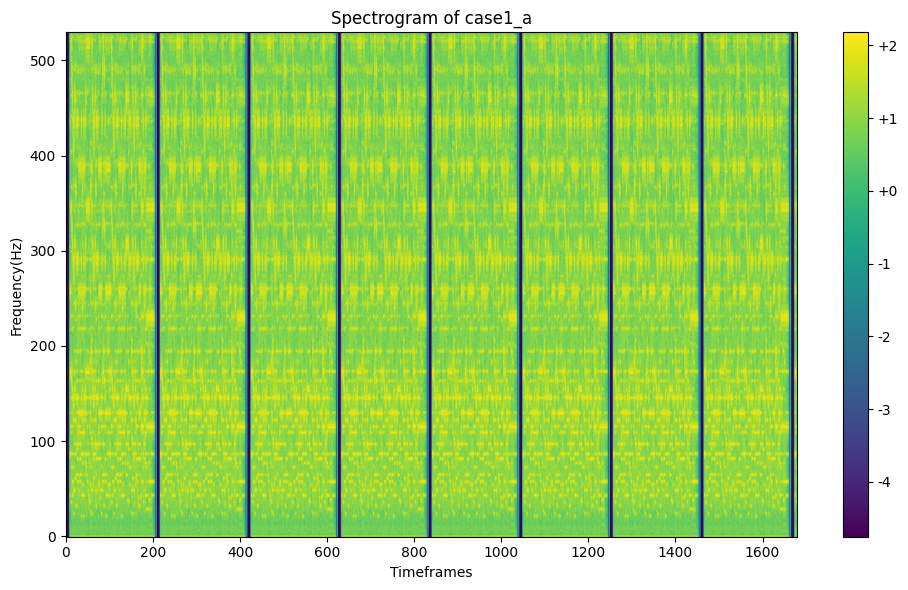

In [101]:
plt.figure(figsize=(10,6))
plt.imshow(np.transpose(spectrogram1)[0], aspect='auto', origin='lower', 
             )


plt.colorbar(format='%+2.0f')
plt.title('Spectrogram of case1_a')
plt.xlabel('Timeframes')
plt.ylabel('Frequency(Hz)')
#plt.ylim(0, 5000)
plt.tight_layout()
plt.savefig('spectrogram_1.png')
plt.show()

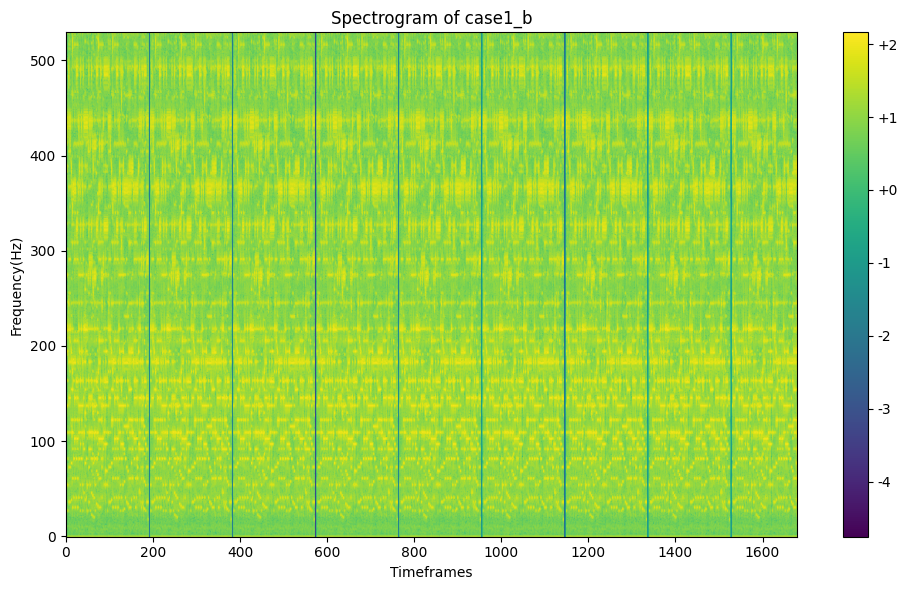

In [102]:
plt.figure(figsize=(10, 6))
plt.imshow(np.transpose(spectrogram2)[0], aspect='auto', origin='lower', 
            )
plt.colorbar(format='%+2.0f')
plt.title('Spectrogram of case1_b')
plt.xlabel('Timeframes')
plt.ylabel('Frequency(Hz)')
#plt.ylim(0, 5000)
plt.tight_layout()
plt.savefig('spectrogram_2.png')
plt.show()

In [17]:
spectrogram= equal_len('plagiarized/case100_b.wav')

In [18]:
spectrogram#.shape#[-1]

<tf.Tensor: shape=(1680, 530, 1), dtype=float32, numpy=
array([[[0.6910915 ],
        [0.71526873],
        [0.75995517],
        ...,
        [1.215111  ],
        [1.1366321 ],
        [1.1580931 ]],

       [[0.37833697],
        [0.7315055 ],
        [0.85954034],
        ...,
        [1.3135157 ],
        [1.3555186 ],
        [1.3687092 ]],

       [[0.44785142],
        [0.5691019 ],
        [0.85967827],
        ...,
        [1.1250284 ],
        [0.9137381 ],
        [0.39339742]],

       ...,

       [[0.5005571 ],
        [0.3557737 ],
        [0.6706307 ],
        ...,
        [1.3107865 ],
        [1.1698322 ],
        [0.9408318 ]],

       [[0.6320853 ],
        [0.56915766],
        [0.772449  ],
        ...,
        [1.51366   ],
        [1.4104277 ],
        [1.567441  ]],

       [[0.43200642],
        [0.04646692],
        [0.53934914],
        ...,
        [2.0711868 ],
        [2.0710518 ],
        [1.7744744 ]]], dtype=float32)>

In [19]:
def preprocess_twin(input_img, validation_img, label):
    processed_input_img = equal_len(input_img)
    processed_validation_img = equal_len(validation_img)
    return processed_input_img, processed_validation_img, label

In [20]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1000)

In [21]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(8)
train_data = train_data.prefetch(4)

In [22]:
test_data = data.skip(round(len(data)*.7))#.take(round(len(data)*.3))
#test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(8)
test_data = test_data.prefetch(4)

# Model

In [26]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten


In [27]:
def make_embedding(): 
    model = Sequential(name='embedding')
    model.add(Conv2D(16, (7, 7), activation='relu', input_shape=(1680, 530, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (7, 7), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (7, 7), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    
    
    return model

In [28]:
embedding = make_embedding()

In [29]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1674, 524, 16)     800       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 837, 262, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 831, 256, 16)      12560     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 415, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 409, 122, 16)      12560     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 204, 61, 16)      0 

In [30]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [31]:
l1 = L1Dist()

In [41]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(1680, 530, 1))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(1680, 530, 1))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [42]:
siamese_model = make_siamese_model()

In [43]:


siamese_model.summary()



Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 1680, 530,   0           []                               
                                1)]                                                               
                                                                                                  
 validation_img (InputLayer)    [(None, 1680, 530,   0           []                               
                                1)]                                                               
                                                                                                  
 embedding (Sequential)         (None, 128)          25511360    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

In [44]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [45]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [46]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [47]:
test_batch = train_data.as_numpy_iterator()

In [48]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 530, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 530, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [49]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative music
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [50]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [51]:


def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)



In [52]:
EPOCHS = 10
history = train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
41/41 [==============================] - 222s 403ms/step
0.33355153 0.5652174 0.7222222

 Epoch 2/10
41/41 [==============================] - 16s 387ms/step
0.6926048 0.63125 0.8278689

 Epoch 3/10
41/41 [==============================] - 16s 388ms/step
0.3174243 0.78881985 0.9007092

 Epoch 4/10
41/41 [==============================] - 16s 398ms/step
0.05998614 0.9404762 0.9461078

 Epoch 5/10
41/41 [==============================] - 17s 415ms/step
0.8844942 0.9815951 0.9756098

 Epoch 6/10
41/41 [==============================] - 17s 425ms/step
0.33933517 0.98214287 0.98802394

 Epoch 7/10
41/41 [==============================] - 19s 467ms/step
0.059694037 0.9876543 0.9815951

 Epoch 8/10
41/41 [==============================] - 21s 504ms/step
0.01445849 1.0 1.0

 Epoch 9/10
41/41 [==============================] - 21s 

In [53]:
from tensorflow.keras.metrics import Precision, Recall

In [54]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [55]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 49ms/step


In [56]:
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_hat ]
y_pred

[0, 1, 0, 1, 1, 0, 1, 1]

In [57]:
y_true

array([0., 1., 0., 1., 1., 0., 1., 1.], dtype=float32)

In [58]:


# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()



1.0

In [59]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [161]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

def calculate_metrics(dataset, model):
    batch_size = 8
    predictions = []
    true_labels = []

    for test_input, test_val, y_true in dataset.as_numpy_iterator():
        batch_predictions = model.predict([test_input, test_val])
        for i in range(len(batch_predictions)):
            if batch_predictions[i]>0.5:
                batch_predictions[i]=1
            else:
                batch_predictions[i]=0
        predictions.extend(batch_predictions)
        true_labels.extend(y_true)

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Calculate metrics using sklearn
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    accuracy = accuracy_score(true_labels, predictions)

    return np.squeeze(predictions, axis=-1), true_labels


In [173]:
pred, true_v = calculate_metrics(test_data, siamese_network)

1/1 [==============================] - 0s 23ms/step


In [174]:
pred, true_v

(array([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        1.], dtype=float32),
 array([0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,

In [187]:
cm = sklearn.metrics.confusion_matrix(true_v, pred)
cm

array([[68,  0],
       [19, 50]], dtype=int64)

In [200]:
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
accuracy

0.8613138686131386

In [198]:
precision = np.diag(cm) / np.sum(cm, axis=0)
precision[0]

0.7816091954022989

In [199]:
recall = np.diag(cm) / np.sum(cm, axis=1)
recall[0]

1.0

# Testing

In [215]:
#first_input = os.path.join('non_plagiarized', 'case3_a.wav')
#second_imput = os.path.join('negatives', 'blues_00001.wav')
first_input = 'X2Download.app-The-Neighbourhood-Sweater-Weather-_Official-Video_-_320-kbps_.wav'
second_imput = 'X2Download.app-SWEATER-WEATHER-SLOWED-_320-kbps_.wav'

In [216]:
prediction = siamese_model.predict(list(np.expand_dims([equal_len(first_input), equal_len(second_imput)], axis=1)))
prediction

1/1 [==============================] - 0s 93ms/step


array([[0.78106743]], dtype=float32)

In [217]:
[1 if prediction > 0.5 else 0]

[1]

# Save model

In [89]:
saved_model_path = './saved_model'
tf.saved_model.save(siamese_model, saved_model_path)

INFO:tensorflow:Assets written to: ./saved_model\assets


INFO:tensorflow:Assets written to: ./saved_model\assets


In [205]:
siamese_model.save('model.h5')

In [206]:
L1Dist

__main__.L1Dist

In [207]:
siamese_model1 = tf.keras.models.load_model('model.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [208]:
siamese_model1.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 1680, 530,   0           []                               
                                1)]                                                               
                                                                                                  
 validation_img (InputLayer)    [(None, 1680, 530,   0           []                               
                                1)]                                                               
                                                                                                  
 embedding (Sequential)         (None, 128)          25511360    ['input_img[0][0]',              
                                                                  'validation_img[0][